In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import mean
from rpy2 import robjects as ro
from rpy2.robjects import pandas2ri
from scipy import interpolate
import os
import datetime as dt

# import R packages
from rpy2.robjects.packages import importr
from scipy.integrate import odeint

#Creating python object representations of R packages.
base = importr('base')
ee = importr('EpiEstim')
lyr = importr('dplyr')
lub = importr('lubridate')

In [2]:
# Define which country you'd like to plot.
realm = "Italy"

#Presumed fatality. Fatality was initially thought to be in the 2%-4% range. More recent evidence suggests
#that the fatality rate is probably somewhere between 0.1-0.5%. (See serological studies in Santa Clara, CA &
# NY State, also the COVID-19 statistics of Island.) Please define fatality as a number between 0 and 1.
# E.g.: 0.004 = 0.4%.
fatality = 0.005

# Define which data you are interested in. Options: "confirmed cases", "deaths", "recovered".
datatype = "confirmed cases"

# Define which should be the first day that you would like to see data from. (Please as: "m/d/yy")
startdate = "2020-03-01"

# Define which should be the last day that you would like to see data from. (Please as: "m/d/yy")
#Data is usually only available up to yesterday. Setting the current day often causes an error.
enddate = "2020-04-23"

#Please specify if you would like to mark the start of social distancing on the plot. For marking it set
# "sd=TRUE" and specify the start date of the social distancing in "yyyy-mm-dd" format. The algorythm will
# automatically also mark the time point where one incubation time has passed after the introduction of
# social distancing measures. Incubation time is assumed to be 7 days (data suggest it could be around
# 5 days, so the efficacy of any measure should start to show within this time.) The assumed incubation time
# can be modified by setting the inc variable.
sd = True
sdstart = "2020-03-15"
inc = 7

In [3]:
def date(usadate):
    datesnums = usadate.split('/', 2)
    if len(datesnums[0]) == 1:
        datesnums[0] = '0' + datesnums[0]
    if len(datesnums[1]) == 1:
        datesnums[1] = '0' + datesnums[1]
    datesnums[2] = '20' + datesnums[2]
    return str(datesnums[2] + '.' + datesnums[0] + '.' + datesnums[1])

In [4]:
def d2i(inc):
    return inc * 1


def neg2zero(data):
    if data < 0:
        return 0
    else:
        return data

In [5]:
# noinspection PyBroadException
def r0ts(lord):
    today = dt.datetime.now().date()
    if lord:
        try:
            filetime = dt.datetime.fromtimestamp(os.path.getctime('global_test'))
        except:
            filetime = dt.datetime.now() - dt.timedelta(1)
        if filetime.date() == today:
            df = pd.read_pickle('global_test')
        else:
            urlglobal = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
            #Because of error_bad_lines the returned database may not contain all countries, exception should be caught downstream.
            df = pd.read_csv(urlglobal, error_bad_lines=False)
            df.to_pickle('global_test')
    else:
        try:
            filetime = dt.datetime.fromtimestamp(os.path.getctime('global_death'))
        except:
            filetime = dt.datetime.now() - dt.timedelta(1)
        if filetime.date() == today:
            df = pd.read_pickle('global_death')
        else:
            urlglobal = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
            df = pd.read_csv(urlglobal, error_bad_lines=False)
            df.to_pickle('global_death')
    return df

In [6]:
def ctry(df, countryname):
    # select country
    country = df[(df['Country/Region'] == countryname)]
    # subselect no province
    country = country[pd.isnull(country['Province/State'])]
    # drop metadata columns
    country.drop(country.columns[np.r_[0:4]], inplace=True, axis=1)
    return country

In [7]:
def world(df, countryname):
    # drop metadata columns
    df.drop(df.columns[np.r_[0:4]], inplace=True, axis=1)
    # sum columns
    worlddf = pd.DataFrame(df.sum()).T
    return worlddf

In [8]:
def cr0(country, lord, shf, countryname):
    # last case
    lastcase = country.iloc[-1].iloc[-1]
    # before last case
    beforecase = country.iloc[-1].iloc[-2]
    # convert cumulative data to incidence
    country = country.diff(axis=1)
    # transpose and reset index (index turned into column)
    country = country.T.reset_index()
    # name columns
    country.columns = ['dates', 'I']
    # custom date-convesrion (variable number of digit problem)
    country['dates'] = country['dates'].apply(lambda rowdate: date(rowdate)).copy(deep=True)
    # datetime conversion
    country['dates'] = pd.to_datetime(country['dates'])
    # get the indexof last zero to get a continous timeseries
    if not country[country['I'] == 0].empty:
        idx = country[country['I'] == 0].index[-1]
        if idx > 30:
            idx = country[country['I'] == 0].index[-2]
    else:
        idx = 0
    country.drop(country.index[0:idx], inplace=True)
    # true incidence from deaths
    if not lord:
        country['I'] = country['I'].apply(lambda inc: d2i(inc)).copy(deep=True)
    # screen for negativ incidence error
    country['I'] = country['I'].apply(lambda data: neg2zero(data)).copy(deep=True)
    # drop the first always nan row
    country = country.iloc[1:]

    # allow rpy onversion
    pandas2ri.activate()
    # convert to r dataframe
    rdf = ro.conversion.py2rpy(country)
    # import functions
    mutate, estimate = lyr.mutate, ee.estimate_R
    # use Date R object instead of datetimeindex (see format) - rx2 gets the column
    rdfd = mutate(rdf, dates=base.as_Date(rdf.rx2('dates').astype('str'), format="%Y-%m-%d %H:%M:%S"))
    res = estimate(incid=rdfd, method="parametric_si",
                   config=ee.make_config(base.list(mean_si=2.6, std_si=1.5)))  # estimate R
    # convert back to pandas dataFrame
    df_r0 = ro.conversion.rpy2py(res)

    # length of R0 series from today back
    rl = len(df_r0[0]['Mean(R)'])
    # contruct a ts form R0
    idx = country['dates'].iloc[-rl:]
    cts = pd.DataFrame(list(df_r0[0]['Mean(R)']), index=country['dates'].iloc[-rl:])
    cts[cts[0] > 5] = 5
    cts.index.freq = 'd'
    if not lord:
        cts.columns = [countryname + '_deaths']
        cts.index = cts.index.shift(shf)
    else:
        cts.columns = [countryname + '_cases']
    return cts, lastcase, beforecase

In [9]:
def ode(r0x, n, r0, i0, plot, country, ax1):
    # R0x = 9
    # Total population, N.
    # N = 8750000
    # Initial number of infected and recovered individuals, I0 and R0.
    # I0, R0 = 1000, 1000
    # Everyone else, S0, is susceptible to infection initially.
    s0 = n - i0 - r0
    # Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
    # beta, gamma = 0.12, 1/10
    gamma = 1 / 10
    beta = r0x.tolist()[0] / (1 / gamma)
    # A grid of time points (in days)
    t = np.linspace(0, 2 * 356, 600)

    # The SIR model differential equations.
    def deriv(y, t, nd, betad, gammad):
        sd, idd, rd = y
        dsdt = -betad * sd * idd / nd
        didt = betad * sd * idd / nd - gammad * idd
        drdt = gammad * idd
        return dsdt, didt, drdt

    # Initial conditions vector
    y0 = s0, i0, r0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(n, beta, gamma))
    s, i, r = ret.T
    
    #Iover temporarely removed because it became an NA if fatality rates over 0.2-0.4% were assumed.
    #iover = np.min(np.where(i < np.max(i) * 0.05))

    if plot:
        # Plot the data on three separate curves for S(t), I(t) and R(t)
        # fig = plt.figure(facecolor='w')
        # ax1 = dfig.add_subplot(221, axisbelow=True)
        ax1.plot(t, s, 'b', alpha=0.5, lw=2, label='Susceptible')
        ax1.plot(t, i, 'r', alpha=0.5, lw=2, label='Infected')
        ax1.plot(t, r, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
        ax1.set_xlabel('Time /days')
        ax1.set_ylabel('Number (millions)')
        ax1.set_ylim(0, n + 2)
        # ax1.yaxis.set_tick_params(length=0)
        # ax1.xaxis.set_tick_params(length=0)
        # ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax1.legend(loc='best', prop={'size': 10})
        # legend.get_frame().set_alpha(0.5)
        
        
        #Old version:
        #ax1.title.set_text(country + ' R0:' + "{:1.2f}".format(r0x.tolist()[0]) + ' - ' + str(iover) + ' days, Dmax:' + "{:1.0f}".format((np.max(i)/1281)*1000000) + '(' + "{:1.0f}".format( i.argmax(axis=0)) + ')' )
        
        #New version adopted because of iover turning NA with lower infectability numbers (alternative could be catching an exception.)
        ax1.title.set_text(country + ' R0:' + "{:1.2f}".format(r0x.tolist()[0]) + 'Dmax: ' + "{:1.0f}".format((np.max(i)/1281)*1000000) + '(' + "{:1.0f}".format( i.argmax(axis=0)) + ')' )
        
        
        # for spine in ('top', 'right', 'bottom', 'left'):
        #    ax1.spines[spine].set_visible(True)

    return s, i, r, r0x

In [10]:
def cntryr0(cnamectr, lord, shf):
    return cr0(ctry(r0ts(lord), cnamectr), lord, shf, cnamectr)


def wrldr0(cnamectr, lord, shf):
    return cr0(world(r0ts(lord), cnamectr), lord, shf, cnamectr)

In [11]:
def wrldplot(pcname, pppl, psh):
    print("Yeah we use the wrldplot!")
    pr0, plc, pbc = wrldr0(pcname, lord=False, shf=psh)
    pr0t, plct, pbct = wrldr0(pcname, lord=True, shf=0)
    presult = pd.concat([pr0, pr0t], join='outer', axis=1)
    plc = plc * (1/fatality)
    pbc = pbc * (1/fatality)
    pcinf = plc / (pppl * 1000000) * 100
    diffinf = pcinf - (pbc / (pppl * 1000000) * 100)
    plt.title(pcname + ' (lag: ' + str(psh) + ' days) ' + "{:4.0f}".format(plc / 1000000) + '/' + str(
        pppl) + ' (millions) : ' + "{:2.2f}".format(pcinf) + '%' + " ({:2.2f}".format(diffinf) + '%)')
    plt.plot(presult)
    plt.axhspan(0.5, 1, facecolor='0.5', alpha=0.5)
    plt.axhspan(1.2, 1.4, facecolor='#ff0000', alpha=0.2)
    #plt.show()

In [12]:
def cntplot(pcname, pppl, psh):
    # plt.figure(figsize=(6, 4))
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10,15))
    fig.autofmt_xdate()
    fig.tight_layout(pad=5.0)

    pr0, plc, pbc = cntryr0(pcname, lord=False, shf=psh)
    pr0t, plct, pbct = cntryr0(pcname, lord=True, shf=0)
    presult = pd.concat([pr0, pr0t], join='outer', axis=1)
    plc = plc * (1/fatality)
    pbc = pbc * (1/fatality)
    pcinf = plc / (pppl * 1000000) * 100
    diffinf = pcinf - (pbc / (pppl * 1000000) * 100)
    s, i, r, rx = ode(np.mean(pr0[-7:]), pppl, pppl*(pcinf/100), pppl*(diffinf/100), True, cname, ax1)

    # ax2 = fig.add_subplot(222)
    ax2.title.set_text('Estimated R0 for ' + pcname + ' (lag: ' + str(psh) + ' days) ' + "{:4.2f}".format(plc / 1000000) + '/' + str(
        pppl) + ' (millions) : ' + "{:2.2f}".format(pcinf) + '%' + " ({:2.2f}".format(diffinf) + '%)')
    ax2.plot(presult, label=presult.columns)
    ax2.legend(presult.columns.values, loc='best', prop={'size': 10})
    ax2.axhspan(0.5, 1, facecolor='0.5', alpha=0.5)
    ax2.axhspan(1.2, 1.4, facecolor='#ff0000', alpha=0.2)

    #plt.show()

In [20]:
def makedatabase(whichdata):
    if whichdata == "confirmed cases":
        df = r0ts(lord=True)
        
    elif whichdata == "deaths":
        df = r0ts(lord=False)
    
    else:
        print("Wrong datatype name.")
        
    #Dropping metadata columns.
    #df.drop(df.columns[np.r_[0:4]], inplace=True, axis=1)
        
    #Transforming dataframe dates to yyyy-mm-dd.
    for x in df.columns[4:]:
        df.rename({str(x): dt.datetime.strptime(str(x), "%m/%d/%y").strftime("%Y-%m-%d")}, inplace=True, axis ="columns")
    
    return df

In [14]:
def extractdate(start, end, df):
    date = df.columns[df.columns.get_loc(start):df.columns.get_loc(end)]
    return date

In [15]:
def extractcountry(df, country, dates):
    inf = df.loc[df["Country/Region"] == country, df.columns.isin(dates)]
    return inf

In [16]:
def countrylogplot(date, inf, sdstart, inc):
    fig, ax = plt.subplots(1,1, figsize=(15,10))
    ax.scatter(np.array(date), inf.iloc[0, :].values)
    ax.set_yscale('log')
    plt.xticks(rotation=90)

    if sd:
        plt.axvline(x=sdstart, label="Social distancing begins", color="r")
        plt.axvline(x=addincubation(sdstart, inc), label="Social distancing begins + 1 incubation time", color="g")
    
    plt.legend(loc=4)

In [17]:
def addincubation(date, inc):
    return str((dt.datetime.strptime(date, "%Y-%m-%d") + dt.timedelta(inc)).strftime("%Y-%m-%d"))

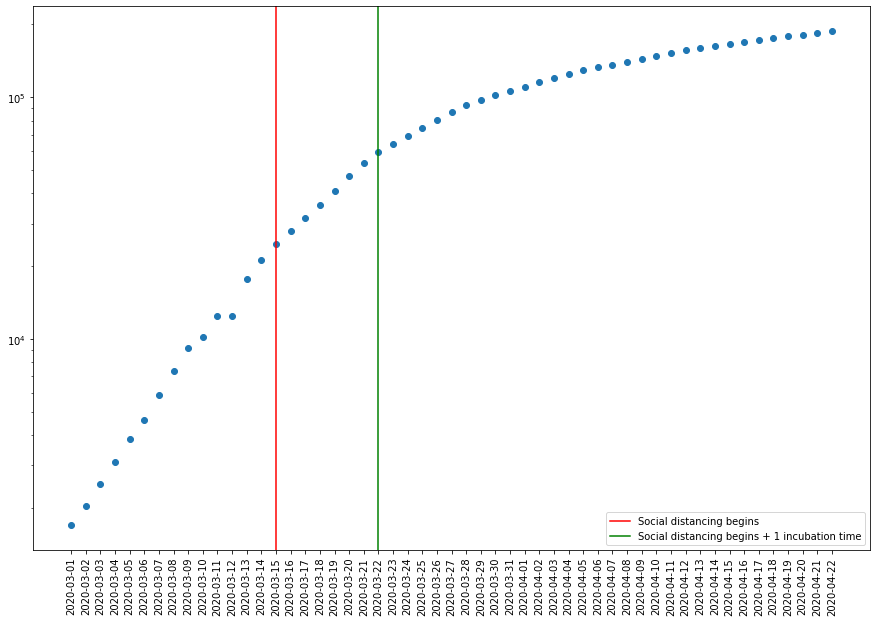

In [21]:
data = makedatabase(datatype)
dates = extractdate(startdate, enddate, data)
country_vec = extractcountry(data, realm, dates)
countrylogplot(dates, country_vec, sdstart, inc)

R[write to console]: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

R[write to console]: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 



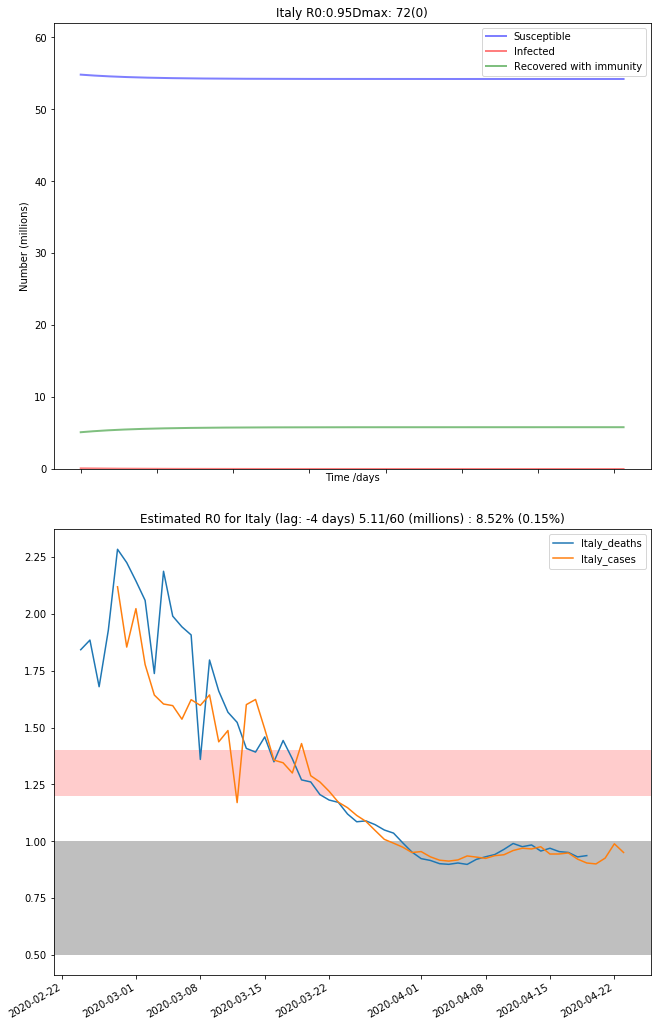

In [22]:
cname = realm
sh = -4
ppl = 60  # millions
cntplot(cname, ppl, sh)
